In [37]:
import numpy as np
import pandas as pd
import datetime
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [38]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [39]:
df_train["outliers"] = np.where(df_train.target < -30, 1, 0)

In [40]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [41]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [42]:
dont_use = [
    'card_id', 
    'first_active_month',
    'second_active_date',
    'diff_first_and_second',
    'target','outliers', 
    'category_1_Y_std', 
    'hist_purchase_date_max',
    'hist_purchase_date_min',
    'hist_category_2_mean_mean',
    'hist_category_3_mean_mean'
]

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target2 = df_train["target"].apply(lambda x:-10 if x<-10 else x)
target_outlier = df_train["outliers"]
target_sign_p = df_train['target'].apply(lambda x:1 if x>=0 else 0)

In [43]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [44]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [45]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target2, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.93195	valid_1's rmse: 1.93923
[200]	training's rmse: 1.89809	valid_1's rmse: 1.90781
[300]	training's rmse: 1.87672	valid_1's rmse: 1.88904
[400]	training's rmse: 1.86196	valid_1's rmse: 1.87686
[500]	training's rmse: 1.85079	valid_1's rmse: 1.86834
[600]	training's rmse: 1.84197	valid_1's rmse: 1.8621
[700]	training's rmse: 1.8346	valid_1's rmse: 1.8576
[800]	training's rmse: 1.82831	valid_1's rmse: 1.85415
[900]	training's rmse: 1.82272	valid_1's rmse: 1.85141
[1000]	training's rmse: 1.81773	valid_1's rmse: 1.84925
[1100]	training's rmse: 1.81309	valid_1's rmse: 1.84741
[1200]	training's rmse: 1.80882	valid_1's rmse: 1.84575
[1300]	training's rmse: 1.80481	valid_1's rmse: 1.84439
[1400]	training's rmse: 1.80102	valid_1's rmse: 1.84321
[1500]	training's rmse: 1.79747	valid_1's rmse: 1.84235
[1600]	training's rmse: 1.79415	valid_1's rmse: 1.84149
[1700]	training's rmse: 1.79094	valid_1's rmse

[3800]	training's rmse: 1.74184	valid_1's rmse: 1.82673
[3900]	training's rmse: 1.73979	valid_1's rmse: 1.82664
[4000]	training's rmse: 1.73771	valid_1's rmse: 1.82661
[4100]	training's rmse: 1.73567	valid_1's rmse: 1.82657
[4200]	training's rmse: 1.73368	valid_1's rmse: 1.82653
[4300]	training's rmse: 1.7317	valid_1's rmse: 1.82647
[4400]	training's rmse: 1.7297	valid_1's rmse: 1.8264
[4500]	training's rmse: 1.72765	valid_1's rmse: 1.8263
[4600]	training's rmse: 1.72567	valid_1's rmse: 1.82626
[4700]	training's rmse: 1.72372	valid_1's rmse: 1.82619
[4800]	training's rmse: 1.72175	valid_1's rmse: 1.82613
[4900]	training's rmse: 1.71974	valid_1's rmse: 1.82608
[5000]	training's rmse: 1.71768	valid_1's rmse: 1.82602
[5100]	training's rmse: 1.71568	valid_1's rmse: 1.826
[5200]	training's rmse: 1.71375	valid_1's rmse: 1.826
[5300]	training's rmse: 1.71186	valid_1's rmse: 1.82594
[5400]	training's rmse: 1.70996	valid_1's rmse: 1.82598
[5500]	training's rmse: 1.7081	valid_1's rmse: 1.82597
[

1.8366379734017573

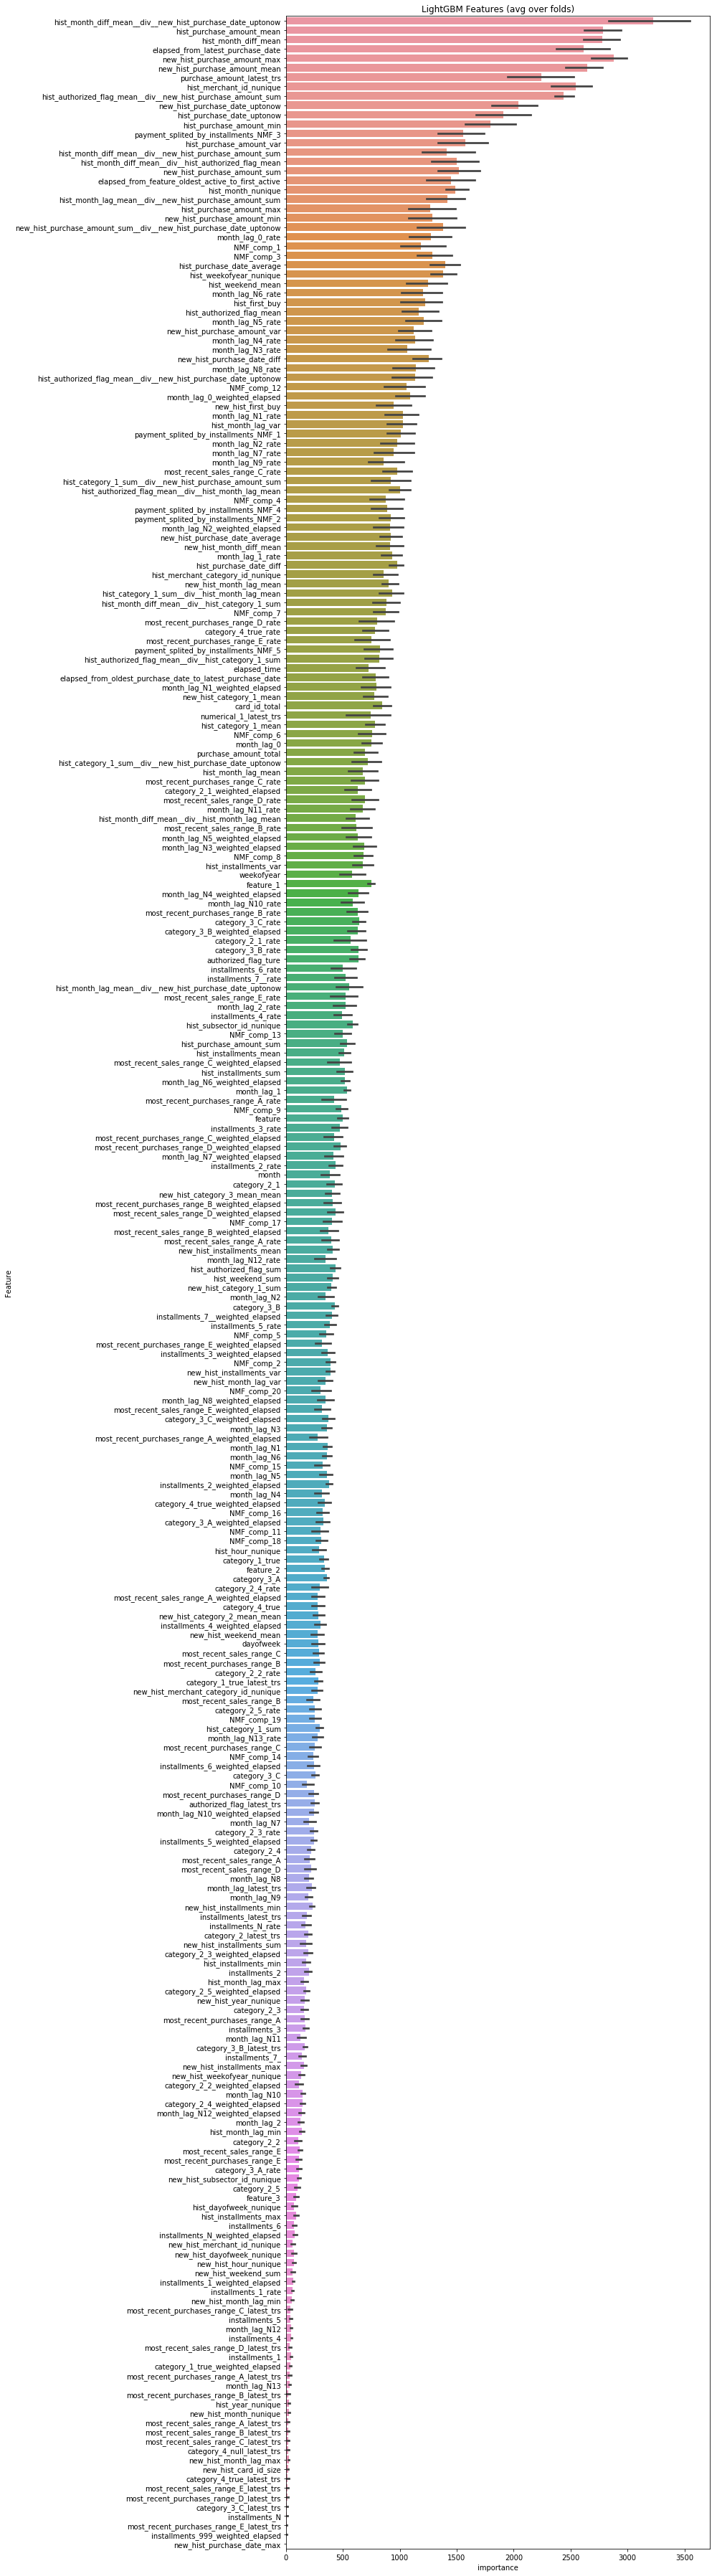

In [46]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [47]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target2.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target2.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target2, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.93203	valid_1's rmse: 1.93914
[200]	training's rmse: 1.89805	valid_1's rmse: 1.90763
[300]	training's rmse: 1.8767	valid_1's rmse: 1.88888
[400]	training's rmse: 1.86206	valid_1's rmse: 1.87665
[500]	training's rmse: 1.85098	valid_1's rmse: 1.86816
[600]	training's rmse: 1.84213	valid_1's rmse: 1.86211
[700]	training's rmse: 1.83473	valid_1's rmse: 1.85754
[800]	training's rmse: 1.82853	valid_1's rmse: 1.85413
[900]	training's rmse: 1.82299	valid_1's rmse: 1.85137
[1000]	training's rmse: 1.81799	valid_1's rmse: 1.84903
[1100]	training's rmse: 1.81335	valid_1's rmse: 1.84702
[1200]	training's rmse: 1.80913	valid_1's rmse: 1.84538
[1300]	training's rmse: 1.80518	valid_1's rmse: 1.84409
[1400]	training's rmse: 1.80142	valid_1's rmse: 1.84299
[1500]	training's rmse: 1.79785	valid_1's rmse: 1.8421
[1600]	training's rmse: 1.79451	valid_1's rmse: 1.84129
[1700]	training's rmse: 1.79125	valid_1's rms

[2700]	training's rmse: 1.76661	valid_1's rmse: 1.82811
[2800]	training's rmse: 1.76419	valid_1's rmse: 1.82797
[2900]	training's rmse: 1.76189	valid_1's rmse: 1.82778
[3000]	training's rmse: 1.75965	valid_1's rmse: 1.82767
[3100]	training's rmse: 1.75736	valid_1's rmse: 1.82755
[3200]	training's rmse: 1.75511	valid_1's rmse: 1.8275
[3300]	training's rmse: 1.7529	valid_1's rmse: 1.82741
[3400]	training's rmse: 1.75065	valid_1's rmse: 1.82725
[3500]	training's rmse: 1.74848	valid_1's rmse: 1.82719
[3600]	training's rmse: 1.74633	valid_1's rmse: 1.82705
[3700]	training's rmse: 1.74422	valid_1's rmse: 1.82698
[3800]	training's rmse: 1.74215	valid_1's rmse: 1.82695
[3900]	training's rmse: 1.74008	valid_1's rmse: 1.82687
[4000]	training's rmse: 1.73796	valid_1's rmse: 1.82685
[4100]	training's rmse: 1.73588	valid_1's rmse: 1.82686
[4200]	training's rmse: 1.73389	valid_1's rmse: 1.82678
[4300]	training's rmse: 1.73191	valid_1's rmse: 1.82673
[4400]	training's rmse: 1.72991	valid_1's rmse: 1.

[5300]	training's rmse: 1.70553	valid_1's rmse: 1.85669
[5400]	training's rmse: 1.70358	valid_1's rmse: 1.85672
[5500]	training's rmse: 1.70167	valid_1's rmse: 1.85668
[5600]	training's rmse: 1.6998	valid_1's rmse: 1.85671
Early stopping, best iteration is:
[5248]	training's rmse: 1.70652	valid_1's rmse: 1.85666


1.8365621100367968

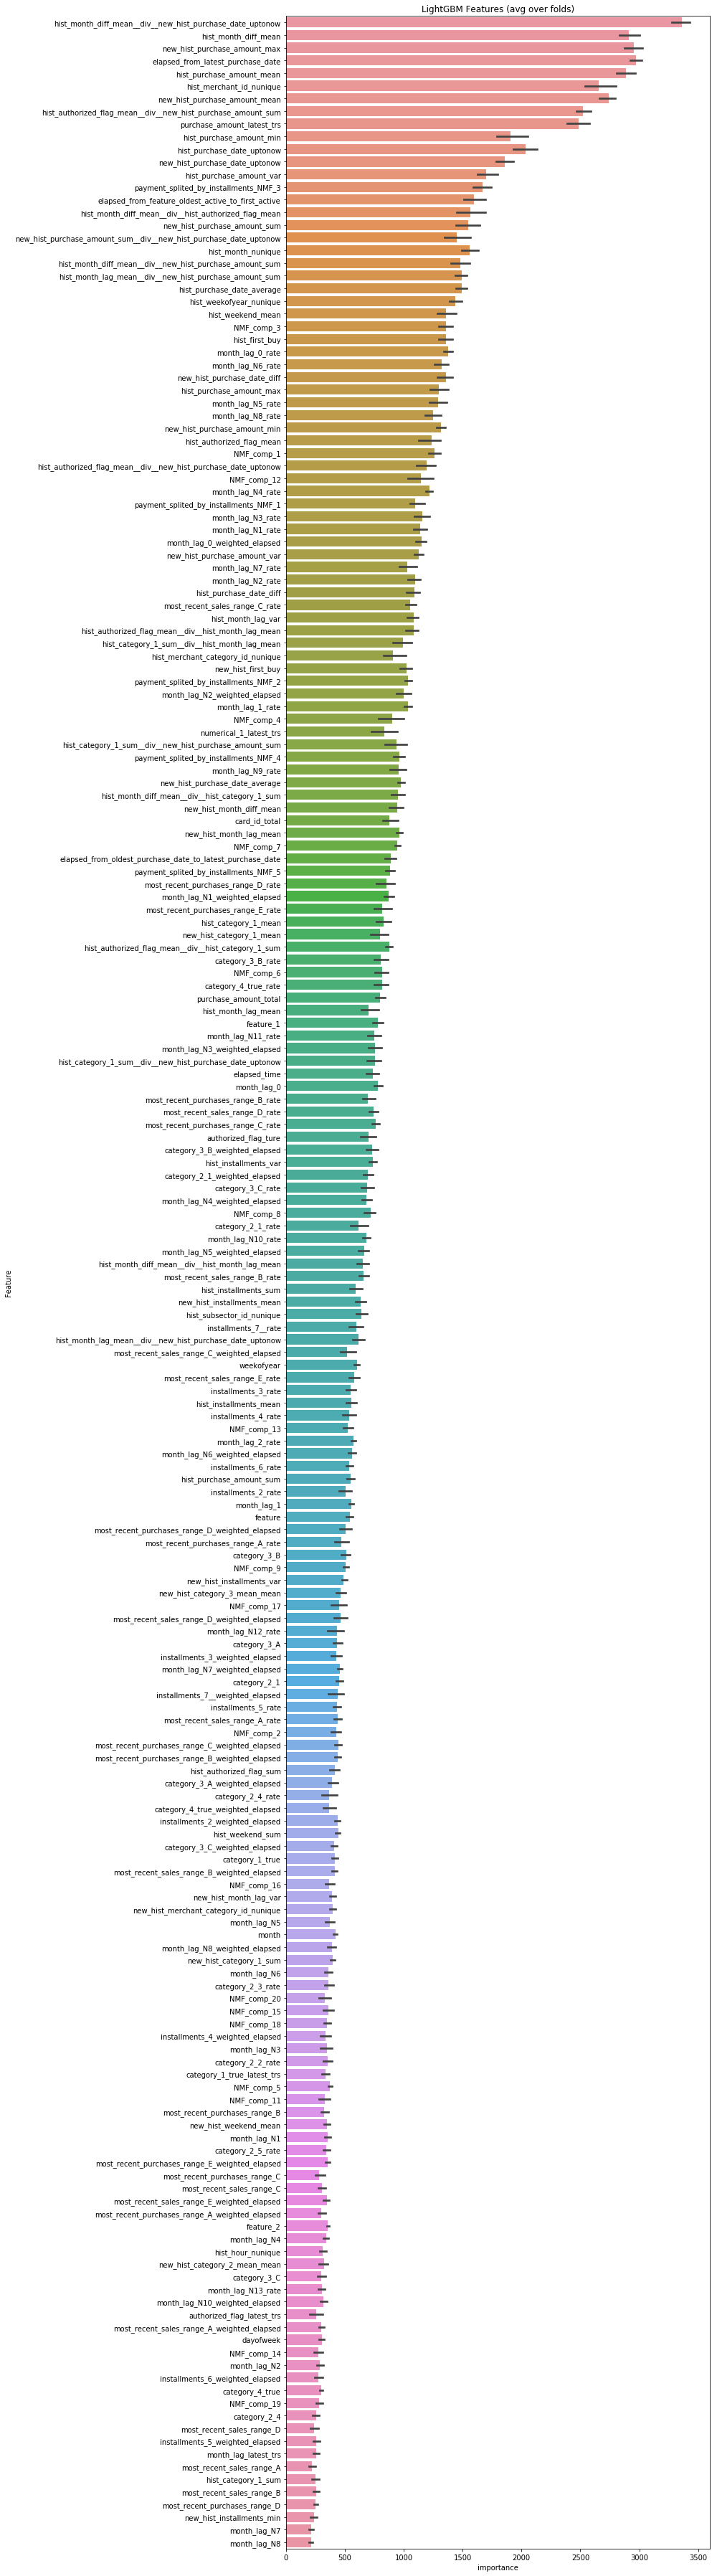

In [48]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [49]:
df_oof = pd.DataFrame({"card_id":df_train.card_id, "target":oof})
df_oof.to_csv("../input/no_outlier_train_20190120.csv", index=False)

In [52]:
df_predict = pd.DataFrame({"card_id":df_test.card_id, "target":predictions})
df_predict.to_csv("../input/no_outlier_test_20190120.csv", index=False)